# Geração do mapa de estações válidas
___

Este notebook gera um mapa contendo as estações que realizam medidas de S4 válidas, isto é, que forneceram alguma medida no período de aquisição destes dados.
No mapa, também é adicionando um shapefile contendo as unidades da federação, pois a versão no basemap apresenta algum erros para o Brasil.
Foi plotado no mapa os meridianos magnéticos associados as estações usando o modelo AACGM para o sistema de coordenadas magnéticas.

In [1]:
import aacgmv2
import os
import sys
import psycopg2

import datetime as dt
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mpl_toolkits.basemap import Basemap
from itertools import chain
from tqdm import tqdm

from utils import local_data
%matplotlib inline

In [2]:
df_station = pd.read_pickle(os.path.join(local_data, 'df_station.pkl'))
df_station

,identificationstation,height,latitude,longitude,state,city,city_heigh,city_latitude,city_longitude
7,cpa,580.000,-22.410000,-45.000000,sp,cachoeira paulista,545.0,-22.67370,-44.9973
8,28,NaN,-3.100000,-59.976000,am,manaus,39.0,-3.10719,-60.0261
9,20,NaN,-20.497000,-54.615000,ms,campo grande,612.0,-20.44350,-54.6478
10,32,NaN,-20.497000,-54.615000,ms,campos grande,612.0,-20.44350,-54.6478
11,nta,0.000,-5.836162,-35.121000,rn,natal,38.0,-5.79448,-35.2110
12,sj2,593.440,-23.207600,-45.859800,sp,sao jose dos campos,593.0,-23.17910,-45.8872
14,16,NaN,-22.823000,-43.238000,rj,rio de janeiro (aeroporto galeão),20.0,-22.90350,-43.2096
15,22,NaN,-22.823000,-43.238000,rj,rio de janeiro (aeroporto galeão),20.0,-22.90350,-43.2096
16,cub,278.000,-15.555200,-56.069800,mt,cuiaba,180.0,-15.59890,-56.0949
17,dou,756.120,-22.110000,-54.550000,ms,dourados,448.0,-22.22180,-54.8064


In [3]:
city_copy = df_station['city'].copy()

city_copy[7] = 'Cachoeira Paulista'
city_copy[8] = 'Manaus'
city_copy[9] = 'Campo Grande'
city_copy[10] = 'Campo Grande'
city_copy[11] = 'Natal'
city_copy[12] = 'São José dos Campos'
city_copy[14] = 'Rio de Janeiro'
city_copy[15] = 'Rio de Janeiro'
city_copy[16] = 'Cuiabá'
city_copy[17] = 'Dourados'
city_copy[18] = 'Fortaleza'
city_copy[19] = 'Rio de Janeiro'
city_copy[20] = 'Guaratinguetá'
city_copy[21] = 'Ilhéus'
city_copy[22] = 'Imperatriz'
city_copy[23] = 'Inconfidentes'
city_copy[24] = 'Macaé'
city_copy[25] = 'Macaé'
city_copy[26] = 'Palmas'
city_copy[27] = 'Petrolina'
city_copy[28] = 'Pirassununga'
city_copy[29] = 'Porto Alegre'
city_copy[30] = 'Presidente Prudente'
city_copy[31] = 'Presidente Prudente'
city_copy[32] = 'Presidente Prudente'
city_copy[33] = 'Presidente Prudente'
city_copy[34] = 'Presidente Prudente'
city_copy[36] = 'São José dos Campos'
city_copy[37] = 'São José dos Campos'
city_copy[39] = 'São Luís do Maranhão'
city_copy[40] = 'Alta Floresta'
city_copy[41] = 'Alta Floresta'
city_copy[42] = 'Belo Horizonte'
city_copy[43] = 'Boa Vista'
city_copy[47] = 'Salvador'
city_copy[48] = 'Tefé'
city_copy[49] = 'Brasília'
city_copy[50] = 'Porto Velho'
city_copy[51] = 'Santa Maria'
city_copy[52] = 'Manaus'

df_station['city_name_correct'] = city_copy.values.ravel()

df_station.sort_values(by=['state', 'city'], inplace=True)

In [4]:
df_station

,identificationstation,height,latitude,longitude,state,city,city_heigh,city_latitude,city_longitude,city_name_correct
8,28,NaN,-3.100000,-59.976000,am,manaus,39.0,-3.10719,-60.0261,Manaus
52,15,NaN,-3.100000,-59.976000,am,manaus,39.0,-3.10719,-60.0261,Manaus
48,tfe,0.057,-3.180000,-64.440000,am,tefe,28.0,-3.32073,-64.7236,Tefé
21,ios,0.000,-14.470000,-39.100000,ba,ilheus,9.0,-14.79730,-39.0355,Ilhéus
47,26,NaN,-13.001000,-38.508000,ba,salvador,12.0,-12.97040,-38.5124,Salvador
18,24,NaN,-3.742000,-38.539000,ce,fortaleza,14.0,-3.71839,-38.5434,Fortaleza
49,bsa,1050.000,-15.764200,-47.869400,df,brasilia,1130.0,-15.78010,-47.9292,Brasília
22,imp,134.720,-5.310000,-47.280000,ma,imperatriz,137.0,-5.52550,-47.4770,Imperatriz
39,29,NaN,-2.574000,-44.209000,ma,são luis do maranhão,17.0,-2.53073,-44.3068,São Luís do Maranhão
42,bhz,858.000,-19.868500,-43.954200,mg,belo horizonte,767.0,-19.81570,-43.9542,Belo Horizonte


In [5]:
df_station = df_station.groupby('city_name_correct').max()
df_station


,identificationstation,height,latitude,longitude,state,city,city_heigh,city_latitude,city_longitude
city_name_correct,,,,,,,,,
Alta Floresta,afl,267.000,-9.870000,-55.900000,mt,alta floresta,264.0,-9.90000,-55.9000
Belo Horizonte,bhz,858.000,-19.868500,-43.954200,mg,belo horizonte,767.0,-19.81570,-43.9542
Boa Vista,bov,69.180,2.833920,-60.695380,rr,boa vista,76.0,2.81954,-60.6714
Brasília,bsa,1050.000,-15.764200,-47.869400,df,brasilia,1130.0,-15.78010,-47.9292
Cachoeira Paulista,cpa,580.000,-22.410000,-45.000000,sp,cachoeira paulista,545.0,-22.67370,-44.9973
Campo Grande,32,NaN,-20.497000,-54.615000,ms,campos grande,612.0,-20.44350,-54.6478
Cuiabá,cub,278.000,-15.555200,-56.069800,mt,cuiaba,180.0,-15.59890,-56.0949
Dourados,dou,756.120,-22.110000,-54.550000,ms,dourados,448.0,-22.22180,-54.8064
Fortaleza,24,NaN,-3.742000,-38.539000,ce,fortaleza,14.0,-3.71839,-38.5434


In [6]:
df_station.to_pickle(os.path.join(local_data, 'df_station_sort.pkl'))

In [7]:
dtime = dt.datetime(2013, 1, 1)
mag_lat = []
mag_lon = []
for i in df_station.itertuples():
    if np.isnan(i.height):
        height = 300
    else:
        height = i.height
    mag_latitude, mag_longitude, _ = aacgmv2.get_aacgm_coord(i.latitude, 
                                                             i.longitude, 
                                                             height, 
                                                             dtime)
    mag_lat.append(mag_latitude)
    mag_lon.append(mag_longitude)
    
df_station['mag_latitude'] = np.array(mag_lat)
df_station['mag_longitude'] = np.array(mag_lon)

In [8]:
dtime = dt.datetime(2013, 1, 1)
mag_meridians_lines = []
for lat, lon in zip(mag_lat, mag_lon):
    lats = np.linspace(-90, 90, 720)
    aux_geo_lat = []
    aux_geo_lon = []
    for i in lats:
        geo_lat, geo_lon, _ = aacgmv2.convert_latlon_arr(i, 
                                                         lon, 
                                                         0, 
                                                         dtime=dtime, 
                                                         code="A2G")
        aux_geo_lat.append(float(geo_lat))
        aux_geo_lon.append(float(geo_lon))
        
    mag_meridians_lines.append((aux_geo_lon, aux_geo_lat))

In [9]:
def draw_map(m, scale=0.2):
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 45), labels=[True, True, True, True])
    lons = m.drawmeridians(np.linspace(-180, 180, 90), labels=[True, True, True, True])
    
    # keys contain the plt.line 2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='b')

/usr/local/anaconda/envs/dscience/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4780: RuntimeWarning: invalid value encountered in greater
  lonsin = np.where(lonsin > lon_0+180, lonsin-360 ,lonsin)
/usr/local/anaconda/envs/dscience/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4781: RuntimeWarning: invalid value encountered in less
  lonsin = np.where(lonsin < lon_0-180, lonsin+360 ,lonsin)
/usr/local/anaconda/envs/dscience/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4787: RuntimeWarning: invalid value encountered in greater_equal
  itemindex = len(lonsin)-np.where(londiff>=thresh)[0]
/usr/local/anaconda/envs/dscience/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4818: RuntimeWarning: invalid value encountered in less
  mask = np.logical_or(lonsin<lon_0-180,lonsin>lon_0+180)
/usr/local/anaconda/envs/dscience/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4818: RuntimeWarning: invalid value encountered in great

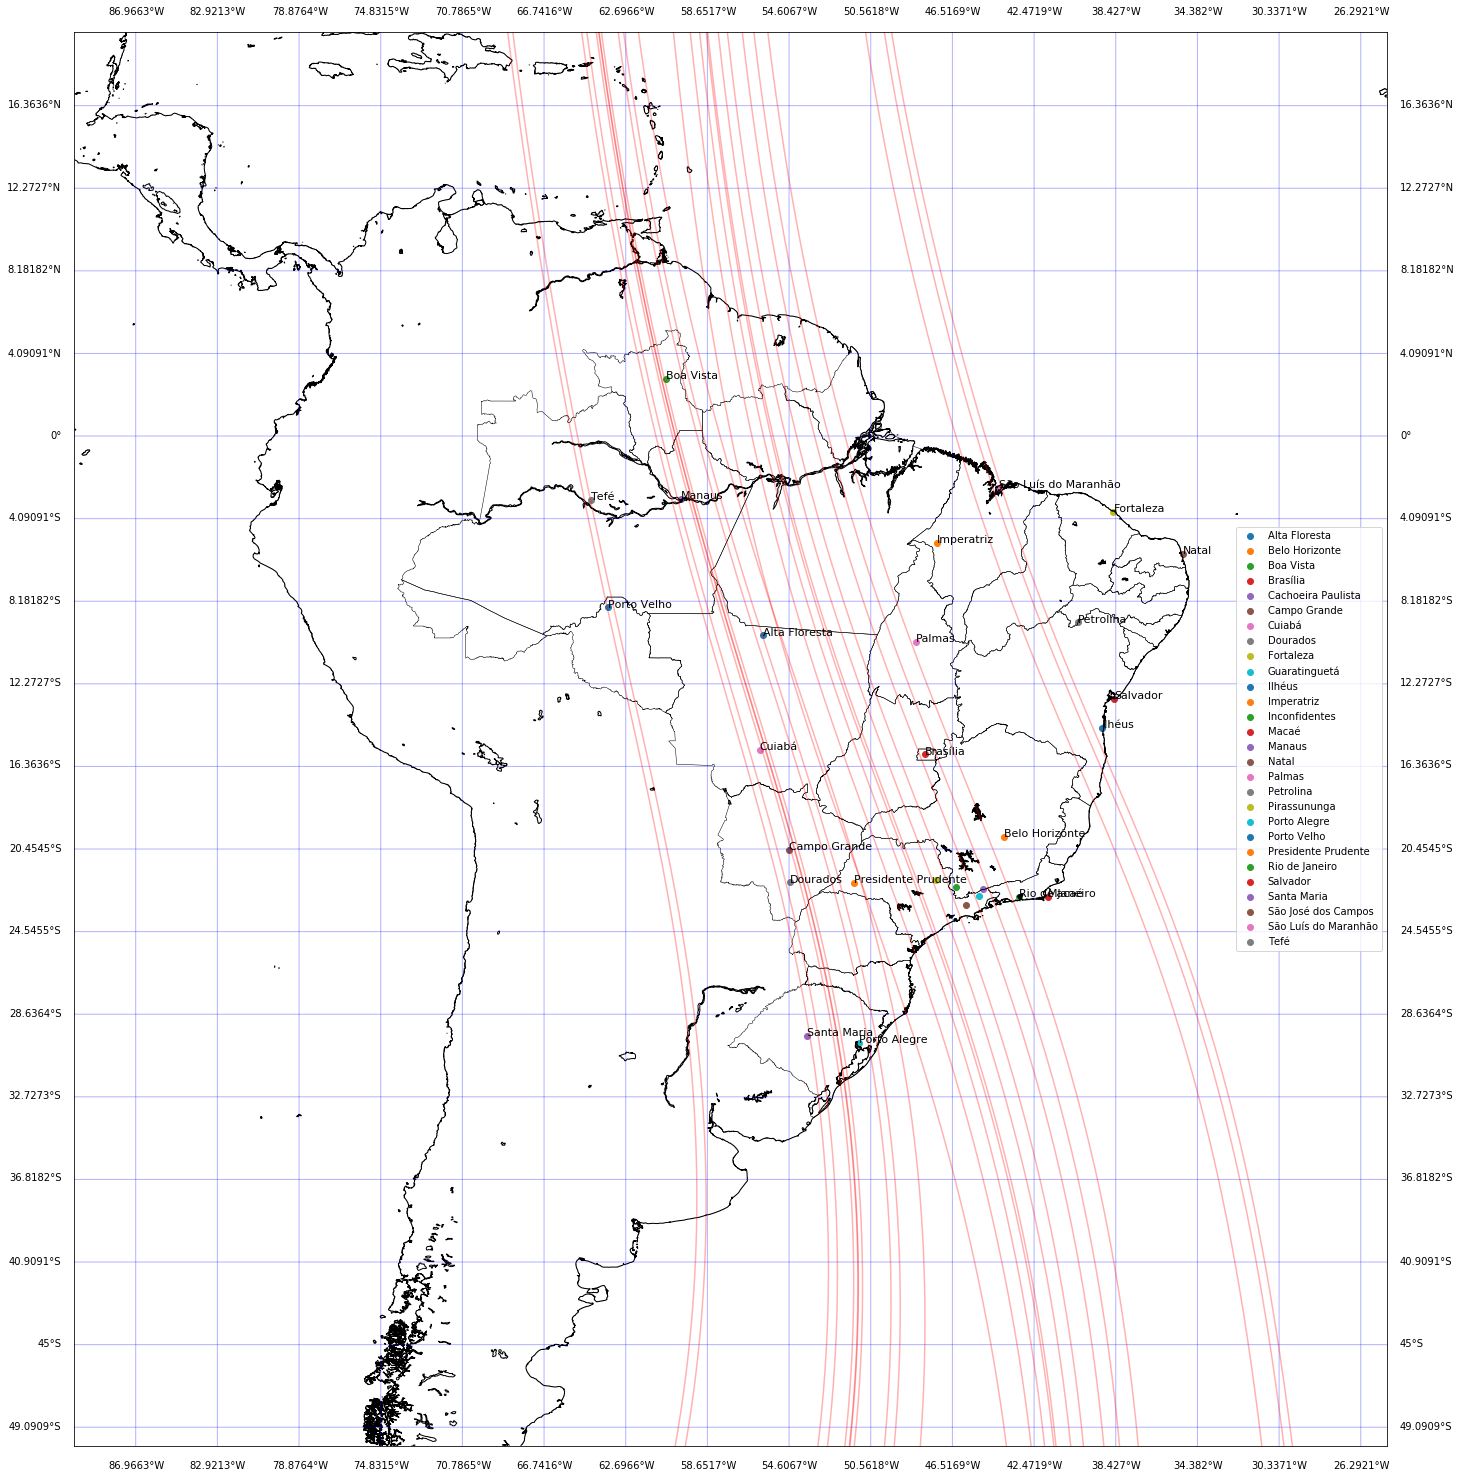

In [10]:
fig = plt.figure(figsize=(26, 26), edgecolor='w')
m = Basemap(projection='cyl',
            resolution='f',
            llcrnrlat=-50,
            urcrnrlat=20,
            llcrnrlon=-90,
            urcrnrlon=-25)
m.drawcoastlines()
m.readshapefile(os.path.join(local_data, 'estados_2010/estados_2010'), 'estados', )
draw_map(m)

for i in mag_meridians_lines:
    m.plot(i[0], i[1], latlon=True, color='r', alpha=0.3)

for i in df_station.itertuples():
    x, y = m(i.longitude, i.latitude)
    m.scatter(x, y, label=i.Index)
    if i.Index not in ['São José dos Campos', 'Cachoeira Paulista', 'Guaratinguetá', 'Inconfidentes', 'Pirassununga']:
        plt.text(x, y, i.Index, fontsize=11)

plt.legend()
plt.savefig('./images/map_stations.svg', format='svg', dpi=1000)
plt.show()

In [11]:
df_station.to_pickle(os.path.join(local_data, 'df_station_sort.pkl'))
df_station.sort_values(by=['state'])

,identificationstation,height,latitude,longitude,state,city,city_heigh,city_latitude,city_longitude,mag_latitude,mag_longitude
city_name_correct,,,,,,,,,,,
Tefé,tfe,0.057,-3.180000,-64.440000,am,tefe,28.0,-3.32073,-64.7236,6.385157,9.314963
Manaus,28,NaN,-3.100000,-59.976000,am,manaus,39.0,-3.10719,-60.0261,13.006630,13.948341
Salvador,26,NaN,-13.001000,-38.508000,ba,salvador,12.0,-12.97040,-38.5124,-16.667647,31.801553
Ilhéus,ios,0.000,-14.470000,-39.100000,ba,ilheus,9.0,-14.79730,-39.0355,-13.470248,30.548727
Fortaleza,24,NaN,-3.742000,-38.539000,ce,fortaleza,14.0,-3.71839,-38.5434,NaN,NaN
Brasília,bsa,1050.000,-15.764200,-47.869400,df,brasilia,1130.0,-15.78010,-47.9292,-24.348659,22.352744
São Luís do Maranhão,29,NaN,-2.574000,-44.209000,ma,são luis do maranhão,17.0,-2.53073,-44.3068,NaN,NaN
Imperatriz,imp,134.720,-5.310000,-47.280000,ma,imperatriz,137.0,-5.52550,-47.4770,NaN,NaN
Belo Horizonte,bhz,858.000,-19.868500,-43.954200,mg,belo horizonte,767.0,-19.81570,-43.9542,-25.426147,24.786619
